In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [447]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

## 1. EDA, Data Cleaning & Feature Engineering

### 1.1 Exploration

In [3]:
# Upload the raw data
data = pd.read_csv("Data-Collisions.csv")

C:\ProgramData\OWTools\miniconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## Create a talbe to see number of unqies and Nan for each feature. This would help us decide which features to drop

def nulls_uniques(df):
    pre_proc = pd.DataFrame()
    pre_proc["uniques"]=df.nunique()
    pre_proc["nulls"] = df.isnull().sum()
    #pre_proc["%"] = pre_proc["nulls"] / 194673*100
    pre_proc["dtypes"] = df.dtypes
    return pre_proc

nulls_uniques(data)

,uniques,nulls,dtypes
SEVERITYCODE,2,0,int64
X,23563,5334,float64
Y,23839,5334,float64
OBJECTID,194673,0,int64
INCKEY,194673,0,int64
COLDETKEY,194673,0,int64
REPORTNO,194670,0,object
STATUS,2,0,object
ADDRTYPE,3,1926,object
INTKEY,7614,129603,float64


In [446]:
## THe label set is relatively unbalanced

print("% of positive results (e.g. 2): ",data.SEVERITYCODE.mean()-1)

% of positive results (e.g. 2):  0.2989012343776487


In [483]:
numerical_columns

['X',
 'Y',
 'PERSONCOUNT',
 'PEDCOUNT',
 'PEDCYLCOUNT',
 'VEHCOUNT',
 'year',
 'hour_cos',
 'hour_sin',
 'month_cos',
 'month_sin',
 'weekday_cos',
 'weekday_sin']

### 1.2 Data Cleaning: First stab

In [485]:
#### DATA CLEANING & FEATURE ENGINEERING #######


## 1. REMOVING DUPLICATING / NOT RELEVANT COLUMNS
## Reasons for removal: 
##             duplication (e.g. SEVERITYCODE.1)
##             useless info (e.g. REPORTNO)
##             categorical info with too many categories (e.g. SEGLANEKEY and CROSSWALKKEY)
##             columns with too many missing values, > 50% of missing values (e.g. EXCEPTRSNCODE, EXCEPTRSNDESC)

columns_to_drop = ["SEVERITYCODE.1", "SEVERITYDESC","SDOTCOLNUM", "REPORTNO", 'SEGLANEKEY', 'CROSSWALKKEY',
                   "INCDATE", "SPEEDING", "PEDROWNOTGRNT", "INTKEY", "INCKEY", "COLDETKEY",
                   "INATTENTIONIND","EXCEPTRSNCODE","EXCEPTRSNDESC", "LOCATION", "OBJECTID", 
                   "ST_COLDESC","SDOT_COLDESC"]
data_cleaned = data.drop(columns = columns_to_drop)


## 2. Converting datetime INCDTTM to pd.datetime format. 

data_cleaned["INCDTTM"] = pd.to_datetime(data_cleaned["INCDTTM"])
data_cleaned["hour"] = data_cleaned["INCDTTM"].dt.hour + data_cleaned["INCDTTM"].dt.minute/60.0
data_cleaned["month"] = data_cleaned["INCDTTM"].dt.month + (data_cleaned["INCDTTM"].dt.day-1)/data_cleaned["INCDTTM"].dt.daysinmonth
data_cleaned["year"] = data_cleaned["INCDTTM"].dt.year + (data_cleaned["month"]-1)/12.0
data_cleaned["weekday"] = data_cleaned["INCDTTM"].dt.weekday


## 3. Various basic data cleaning activities
data_cleaned.loc[data_cleaned.UNDERINFL=="1", "UNDERINFL"] = "Y"
data_cleaned.loc[data_cleaned.UNDERINFL=="0", "UNDERINFL"] = "N"

data_cleaned.loc[data_cleaned.ST_COLCODE==" ", "ST_COLCODE"] = np.nan
data_cleaned.ST_COLCODE = data_cleaned.ST_COLCODE.astype(float)

# Converting to string so we can make categorical dummy columns out of these
data_cleaned.ST_COLCODE = data_cleaned.ST_COLCODE.astype(str)
data_cleaned.SDOT_COLCODE = data_cleaned.SDOT_COLCODE.astype(str)



## 4. REMOVE rows with NA in the remaining columns
## Reasonable to do so as we only lose ~7.5% of data and keep the same balance in our label set

data_cleaned = data_cleaned[~data_cleaned[["WEATHER","ROADCOND","LIGHTCOND", "JUNCTIONTYPE", "JUNCTIONTYPE",
                                          "COLLISIONTYPE", "X", "Y", "UNDERINFL", "ST_COLCODE",
                                          "ADDRTYPE"]].isnull().any(axis=1)].reset_index(drop=True)


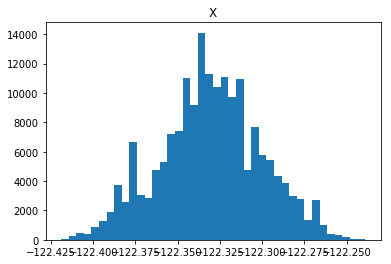

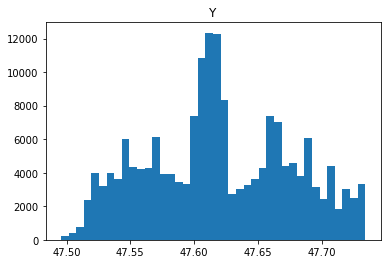

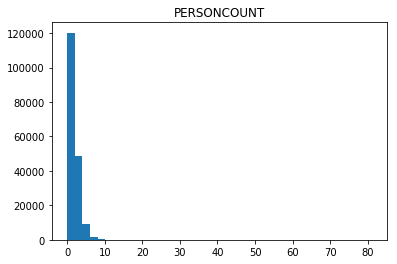

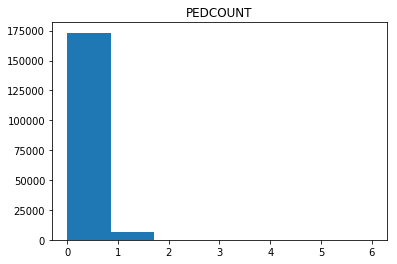

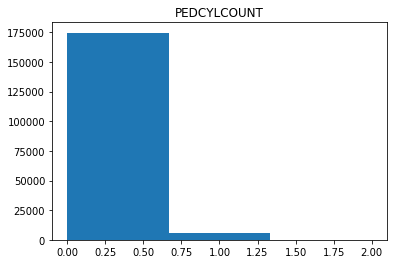

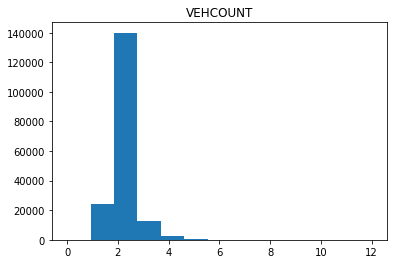

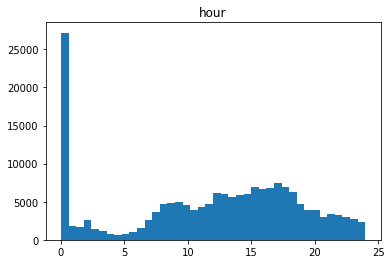

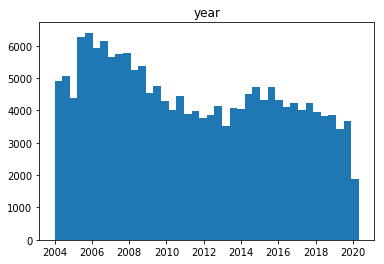

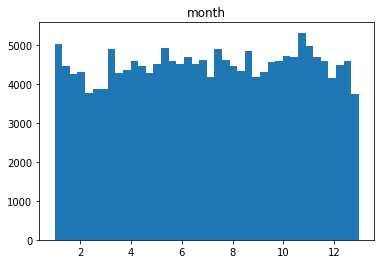

In [486]:
## We plot hte distributions for each of the numerical columns
## We noticed a huge spike in hours for 00:00:00 - looks like this is a default value
## Otherwise distributions look quite normal - no other weird spikes

def hist_plot(df):
    for i in df.columns:
        plt.title(i)
        plt.hist(df[i],bins = min(len(df[i].drop_duplicates()),40))
        plt.show()
        
hist_plot(data_cleaned[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT', "hour", "year", "month"]])

### 1.3 Feature Engineering & further Data Cleaning

In [516]:
##  1. We also noticed that there are lots of values (~24k entries) that have 00:00:00 INCDTTM value. 
##  Looks like this is a default value that was inputted instead of the real incident time. 
##  For now we would remove those losing around ~12% of data. We will reassess whether we need to add these entries back 

data_cleaned2 = data_cleaned[data_cleaned["INCDTTM"].dt.strftime("%X")!="00:00:00"]


##  2. Here we want to tackle the issue of ciclicality of time.  
##  We would extract year, month, hour and weekday from pd.datetime as we've seen that those individual pices might 
##  carry useful info for our model (e.g. less accidents on Sunday). 
##  Then we will convert each individual feature to two features (sin) and (cos) to make sure we convey the 
##  cyclicality of the data (e.g. 23:59 is very close to 00:01)

#data_cleaned2["hour"] = data_cleaned2["INCDTTM"].dt.hour + data_cleaned2["INCDTTM"].dt.minute/60.0
#data_cleaned2["month"] = data_cleaned2["INCDTTM"].dt.month + (data_cleaned2["INCDTTM"].dt.day-1)/data_cleaned2["INCDTTM"].dt.daysinmonth
#data_cleaned2["year"] = data_cleaned2["INCDTTM"].dt.year + (data_cleaned2["month"]-1)/12.0
#data_cleaned2["weekday"] = data_cleaned2["INCDTTM"].dt.weekday

data_cleaned2["hour_cos"] = np.cos(data_cleaned2["hour"]*2*np.pi/24)
data_cleaned2["hour_sin"] = np.sin(data_cleaned2["hour"]*2*np.pi/24)

data_cleaned2["month_cos"] = np.cos(data_cleaned2["month"]*2*np.pi/13)
data_cleaned2["month_sin"] = np.sin(data_cleaned2["month"]*2*np.pi/13)

data_cleaned2["weekday_cos"] = np.cos(data_cleaned2["weekday"]*2*np.pi/7)
data_cleaned2["weekday_sin"] = np.sin(data_cleaned2["weekday"]*2*np.pi/7)


data_cleaned2 = data_cleaned2.drop(columns = ["INCDTTM","hour","month","weekday"])
#data_cleaned2 = data_cleaned2.drop(columns = ["INCDTTM"])

C:\ProgramData\OWTools\miniconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\OWTools\miniconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\OWTools\miniconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [517]:
### CREATING DUMMIES FOR CATEGORICAL VARIABLES

label = ["SEVERITYCODE"]

categorical_columns = ['STATUS', 'ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE',
        'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'HITPARKEDCAR','ST_COLCODE','SDOT_COLCODE']

numerical_columns = [i for i in data_cleaned2.columns.to_list() if i not in categorical_columns+ label]


categorical = pd.get_dummies(data_cleaned2[categorical_columns])

data_process = pd.concat([data_cleaned2[label], data_cleaned2[numerical_columns], categorical], sort=False, axis = 1)

In [602]:
data_process

,SEVERITYCODE,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,year,hour_cos,hour_sin,...,SDOT_COLCODE_53,SDOT_COLCODE_54,SDOT_COLCODE_55,SDOT_COLCODE_56,SDOT_COLCODE_58,SDOT_COLCODE_61,SDOT_COLCODE_64,SDOT_COLCODE_66,SDOT_COLCODE_68,SDOT_COLCODE_69
0,2,-122.323148,47.703140,2,0,0,2,2013.236559,-0.725374,-0.688355,...,0,0,0,0,0,0,0,0,0,0
1,1,-122.347294,47.647172,2,0,0,2,2006.967742,0.237686,-0.971342,...,0,0,0,0,0,0,0,0,0,0
2,1,-122.334540,47.607871,4,0,0,3,2004.880556,-0.906308,0.422618,...,0,0,0,0,0,0,0,0,0,0
3,1,-122.334803,47.604803,3,0,0,3,2013.241935,-0.782608,0.622515,...,0,0,0,0,0,0,0,0,0,0
4,2,-122.306426,47.545739,2,0,0,2,2004.072581,-0.515038,0.857167,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180062,2,-122.290826,47.565408,3,0,0,2,2018.863889,-0.544639,0.838671,...,0,0,0,0,0,0,0,0,0,0
180063,1,-122.344526,47.690924,2,0,0,2,2018.962366,-0.748956,0.662620,...,0,0,0,0,0,0,0,0,0,0
180064,2,-122.306689,47.683047,3,0,0,2,2019.048387,-0.779884,0.625923,...,0,0,0,0,0,0,0,0,0,0
180065,2,-122.355317,47.678734,2,0,1,1,2019.037634,-0.309017,-0.951057,...,0,0,0,0,0,0,0,0,0,0


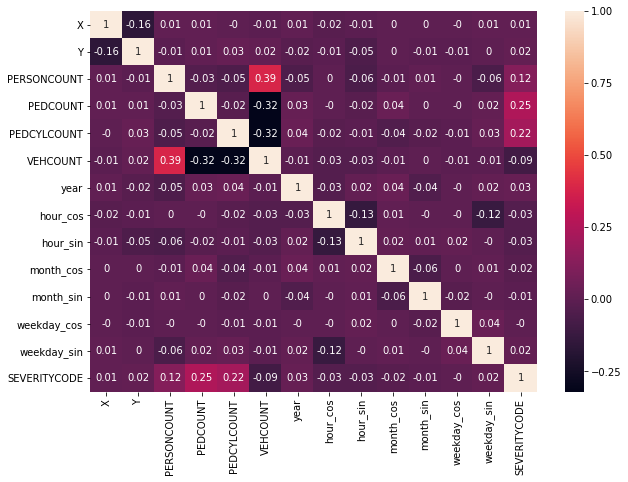

In [623]:
## Output coorelation matrix for numerical columns. 
## It looks like we don't have any strongly correlated variables
plt.figure(figsize=(10,7))
sns.heatmap(data_process[numerical_columns+label].corr().round(2), annot=True)
plt.show()

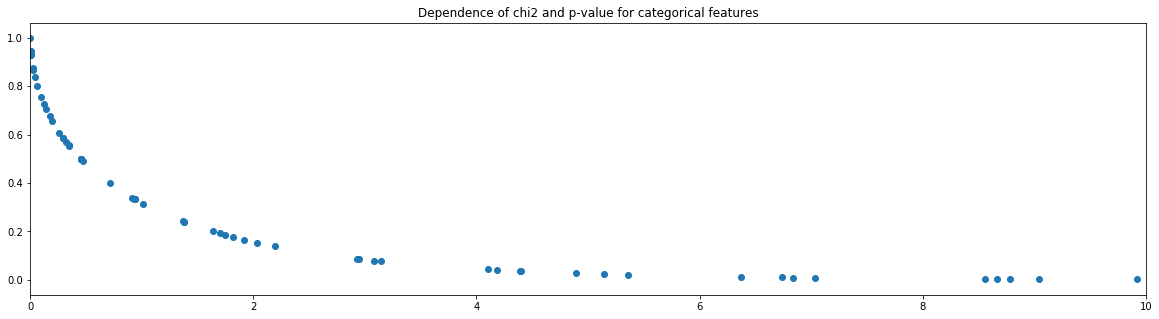

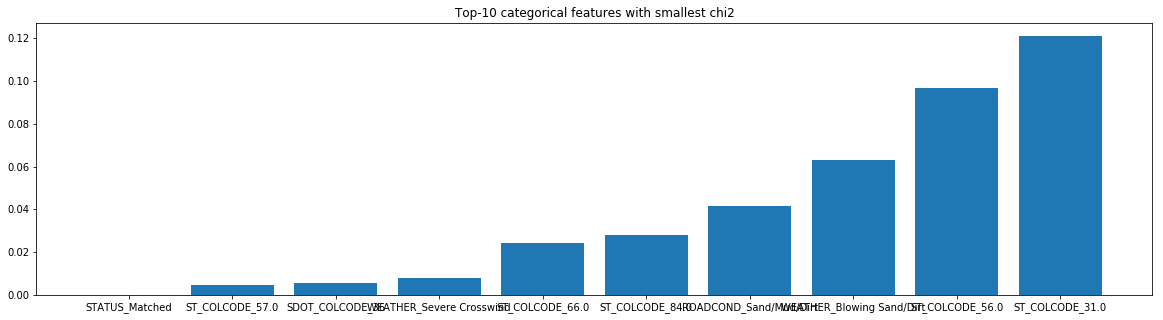

                       columns      chi2         p
0               STATUS_Matched  0.000003  0.998634
96             ST_COLCODE_57.0  0.004683  0.945440
137            SDOT_COLCODE_36  0.005776  0.939419
30    WEATHER_Severe Crosswind  0.007982  0.928811
100            ST_COLCODE_66.0  0.024213  0.876345
111            ST_COLCODE_84.0  0.027843  0.867479
38      ROADCOND_Sand/Mud/Dirt  0.041805  0.837993
23   WEATHER_Blowing Sand/Dirt  0.062894  0.801979
95             ST_COLCODE_56.0  0.096850  0.755643
79             ST_COLCODE_31.0  0.121063  0.727885


In [622]:
## Output chi2 test results for categorical values 
## We see that there are some features that are quite insignificant and can be considered for removal in future iterations. 
## Otherwise we have a bunch of features that are statistically significant in regards to the target variable 

temp = pd.DataFrame()
temp["columns"] = [i for i in data_process.columns if i not in numerical_columns+label]

temp["chi2"] = chi2(data_process[[i for i in data_process.columns if i not in numerical_columns+label]], 
                    data_process[["SEVERITYCODE"]])[0]

temp["p"] = chi2(data_process[[i for i in data_process.columns if i not in numerical_columns+label]], 
                 data_process[["SEVERITYCODE"]])[1]


plt.figure(2, figsize=(20,5))
plt.title("Dependence of chi2 and p-value for categorical features")
axes = plt.gca()
axes.set_xlim([0,10])
plt.scatter(temp["chi2"],temp["p"])


plt.figure(1, figsize=(20,5))
plt.title("Top-10 categorical features with smallest chi2")
temp = temp.sort_values(by = ["chi2"],ascending = True).head(10)
plt.bar( temp["columns"], temp["chi2"] )


plt.show()
print(temp)

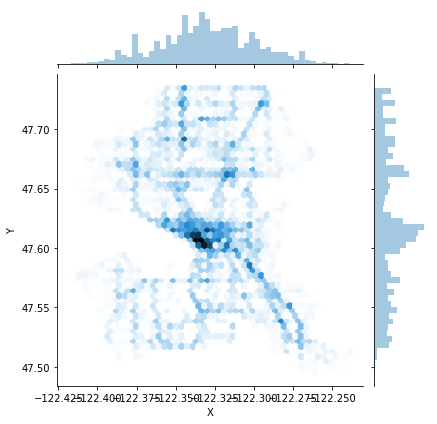

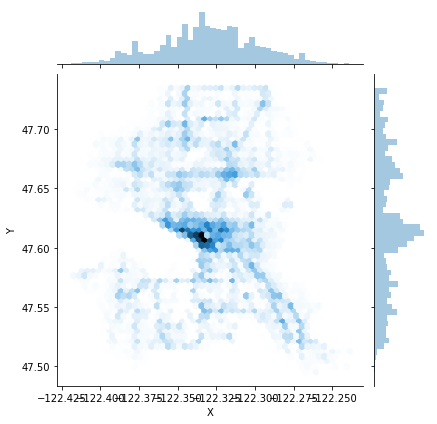

In [454]:
## Plotting X and Y coordinates for severe accidents and non-severe ones. 
## We see that there is a subtle difference in where more severe accidents occured (usually city centres) 

sns.jointplot(data_process[data_process["SEVERITYCODE"]==2]["X"], data_process[data_process["SEVERITYCODE"]==2]["Y"], kind="hex")
sns.jointplot(data_process[data_process["SEVERITYCODE"]==1]["X"], data_process[data_process["SEVERITYCODE"]==1]["Y"], kind="hex")
plt.show()

## 2. Training

In [518]:
## SPLITTING INTO X AND Y

y = data_process[['SEVERITYCODE']].replace(1,0).replace(2,1)
x = data_process.drop(columns = ["SEVERITYCODE"])

In [519]:
test_size = 0.20

x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    random_state = 1, test_size  = test_size, stratify = y)

In [520]:
## Creating balanced version of the data
y_pos = y["SEVERITYCODE"]==1

x_train_bal = pd.concat([x_train[~y_pos].sample(len(y_train[y_pos])), x_train.loc[y_train[y_pos].index]])
y_train_bal = y_train.loc[x_train_bal.index]

C:\ProgramData\OWTools\miniconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\OWTools\miniconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\OWTools\miniconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [521]:
## Creating sample version of the trained and test data to perform GridSearch on them

x_sampled = x_train_bal.sample(30000)
y_sampled = y_train_bal.loc[x_sampled.index]

In [589]:
## Creating two standardized versions for trained and test data
sc = StandardScaler()

x_train_bal_sc = x_train_bal.copy()
x_test_sc = x_test.copy()
x_train_bal_sc[numerical_columns] = sc.fit_transform(x_train_bal_sc[numerical_columns])
x_test_sc[numerical_columns] = sc.transform(x_test_sc[numerical_columns])

x_train_sc = x_train.copy()
x_train_sc[numerical_columns] = sc.fit_transform(x_train_sc[numerical_columns])

C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\OWTools\miniconda\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype in

In [523]:
## HELPER FUNCTIONS

def results(y_true, y_pred, y_prob):
    print("Accuracy: ",round(accuracy_score(y_true,y_pred),3))
    print("Balanced accuracy score", round(balanced_accuracy_score(y_true, y_pred),3))
    print("Confusion matrix: \n", confusion_matrix(y_true,y_pred), "\n",confusion_matrix(y_true,y_pred)/len(y_pred))
    print("F1 score: ", round(f1_score(y_true,y_pred),3))
    print("Recall: ", round(recall_score(y_true,y_pred),3))
    print("Precision: ", round(precision_score(y_true,y_pred),3))
    print("ROC AUC score: ", round(roc_auc_score(y_true,y_prob),3))

def ROC_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
    
    plt.plot(fpr,tpr, color = "blue")
    plt.plot([0,1],[0,1], color="red")
    plt.show()
    
def feature_importance(column_names, feature_importance, show_num):
    figure = plt.figure(figsize= (20,5))

    temp = pd.DataFrame()
    temp["columns"] = column_names
    temp["importance"] = feature_importance

    temp = temp.sort_values(by = ["importance"],ascending = False).head(show_num)
    plt.bar( temp["columns"], temp["importance"] )
    plt.show()

### 2.1 MULTIVARIABLE LOGISTIC REGRESSION

In [524]:
## Set up a grid search to find the most optimal regularization parameters

lr = LogisticRegression()

parameters = {'C':[10**i for i in range(-3,3)],'penalty':['l2','l1']}

gs_lr = GridSearchCV(lr, parameters, verbose=2) 
gs_lr.fit(x_train_bal_sc,y_train_bal)


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.001, penalty=l2 .............................................
[CV] .............................. C=0.001, penalty=l2, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=0.001, penalty=l2, total=   0.3s
[CV] C=0.001, penalty=l2 .............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=0.001, penalty=l2, total=   0.3s
[CV] C=0.001, penalty=l1 .............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=0.001, penalty=l1, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=0.001, penalty=l1, total=   0.3s
[CV] C=0.001, penalty=l1 .............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=0.001, penalty=l1, total=   0.3s
[CV] C=0.01, penalty=l2 ..............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................... C=0.01, penalty=l2, total=   0.4s
[CV] C=0.01, penalty=l2 ..............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................... C=0.01, penalty=l2, total=   0.4s
[CV] C=0.01, penalty=l2 ..............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................... C=0.01, penalty=l2, total=   0.5s
[CV] C=0.01, penalty=l1 ..............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................... C=0.01, penalty=l1, total=   0.5s
[CV] C=0.01, penalty=l1 ..............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................... C=0.01, penalty=l1, total=   0.4s
[CV] C=0.01, penalty=l1 ..............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................... C=0.01, penalty=l1, total=   0.7s
[CV] C=0.1, penalty=l2 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=0.1, penalty=l2, total=   0.9s
[CV] C=0.1, penalty=l2 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=0.1, penalty=l2, total=   0.7s
[CV] C=0.1, penalty=l2 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=0.1, penalty=l2, total=   0.7s
[CV] C=0.1, penalty=l1 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=0.1, penalty=l1, total=   1.2s
[CV] C=0.1, penalty=l1 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=0.1, penalty=l1, total=   0.5s
[CV] C=0.1, penalty=l1 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=0.1, penalty=l1, total=   0.4s
[CV] C=1, penalty=l2 .................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................................. C=1, penalty=l2, total=   1.4s
[CV] C=1, penalty=l2 .................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................................. C=1, penalty=l2, total=   1.2s
[CV] C=1, penalty=l2 .................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................................. C=1, penalty=l2, total=   1.2s
[CV] C=1, penalty=l1 .................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................................. C=1, penalty=l1, total=   3.5s
[CV] C=1, penalty=l1 .................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................................. C=1, penalty=l1, total=   2.0s
[CV] C=1, penalty=l1 .................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................................. C=1, penalty=l1, total=   2.5s
[CV] C=10, penalty=l2 ................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. C=10, penalty=l2, total=   2.6s
[CV] C=10, penalty=l2 ................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. C=10, penalty=l2, total=   2.8s
[CV] C=10, penalty=l2 ................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. C=10, penalty=l2, total=   2.5s
[CV] C=10, penalty=l1 ................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. C=10, penalty=l1, total=  11.0s
[CV] C=10, penalty=l1 ................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. C=10, penalty=l1, total=   6.2s
[CV] C=10, penalty=l1 ................................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................. C=10, penalty=l1, total=   3.6s
[CV] C=100, penalty=l2 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=100, penalty=l2, total=   3.6s
[CV] C=100, penalty=l2 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=100, penalty=l2, total=   4.0s
[CV] C=100, penalty=l2 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=100, penalty=l2, total=   4.2s
[CV] C=100, penalty=l1 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=100, penalty=l1, total=  10.0s
[CV] C=100, penalty=l1 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=100, penalty=l1, total=   3.7s
[CV] C=100, penalty=l1 ...............................................


C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................................ C=100, penalty=l1, total=   4.1s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.4min finished
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [525]:
## Output the restils of the model
y_pred = gs_lr.best_estimator_.predict(x_test_sc)
results(y_test, y_pred, gs_lr.best_estimator_.predict_proba(x_test_sc)[:,1] )

Accuracy:  0.675
Balanced accuracy score 0.709
Confusion matrix: 
 [[13230  8123]
 [ 1968  7760]] 
 [[0.42566198 0.26134938]
 [0.06331843 0.24967022]]
F1 score:  0.606
Recall:  0.798
Precision:  0.489
ROC AUC score:  0.791


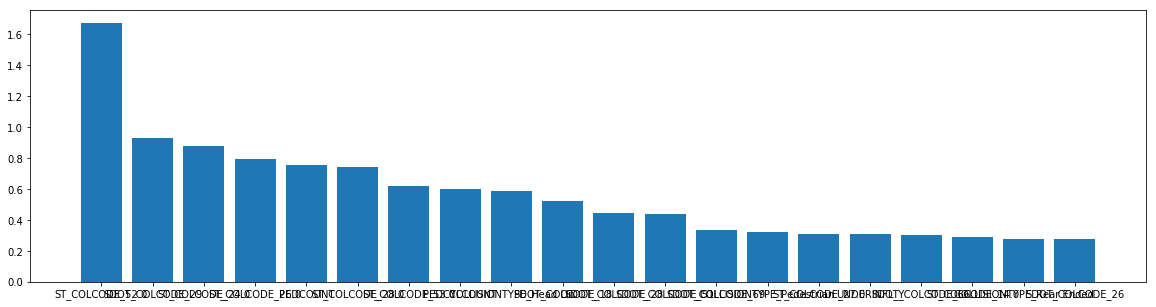

In [497]:
feature_importance(x_sampled.columns, gs_lr.best_estimator_.coef_[0],20)

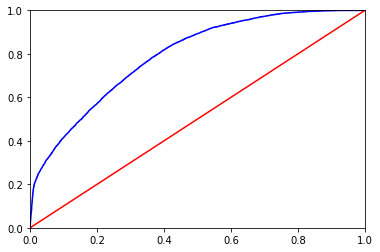

In [531]:
ROC_curve(y_test,gs_lr.best_estimator_.predict_proba(x_test_sc)[:,1])


### 2.2 Random Forest

In [536]:
rf = RandomForestClassifier(random_state=42, verbose = 2)

parameters = {'n_estimators':[200,300,500],
              "max_depth": [5,7,10, None],
              #"max_features": ['sqrt','log2'],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 3, 4, 5]
             }

gs_rf = RandomizedSearchCV(rf, parameters, verbose = 2, n_jobs = 4, cv = 3, n_iter = 20)

gs_rf.fit(x_sampled, y_sampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   47.6s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  1.6min finished
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   10.5s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=2, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=4,
          param_distributions={'n_estimators': [200, 300, 500], 'max_depth': [5, 7, 10, None], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=2)

In [543]:
rf = gs_rf.best_estimator_

rf.fit(x_train_bal, y_train_bal)

C:\ProgramData\OWTools\miniconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 30

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   34.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

In [545]:
results(y_test,rf.predict(x_test),rf.predict_proba(x_test)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Accuracy:  0.683
Balanced accuracy score 0.713
Confusion matrix: 
 [[13532  7821]
 [ 2028  7700]] 
 [[0.43537853 0.25163283]
 [0.06524887 0.24773978]]
F1 score:  0.61
Recall:  0.792
Precision:  0.496
ROC AUC score:  0.797


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.8s finished


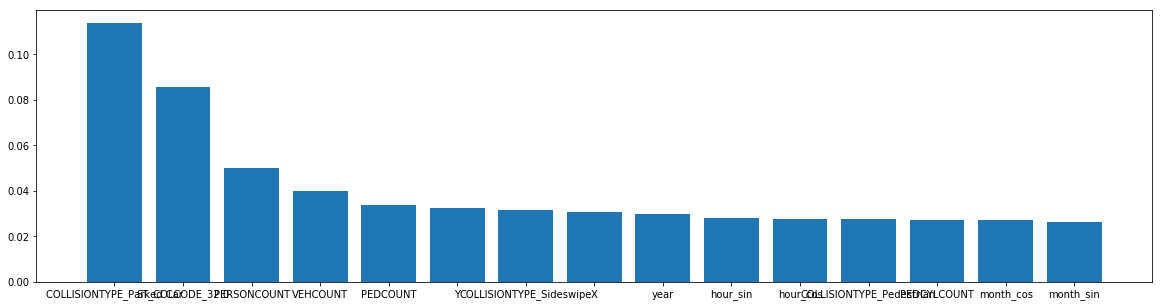

In [544]:
feature_importance(x_sampled.columns, rf.feature_importances_,15)

### 2.3 XGBOOST

In [546]:
xg = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.01,
                n_estimators = 700, silent = False)#, alpha = 10) 

parameters = {
        'min_child_weight': [1,3, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.3, 0.6, 0.8],
        'max_depth': [3, 4, 5,6,7,8],
        #'scale_pos_weight' : [1, 10, 25, 50, 75, 99, 100, 1000]
        }

gs_xg =  RandomizedSearchCV(xg, parameters, scoring = 'accuracy', verbose = 3, n_jobs = 2, cv = 3, n_iter = 20)

#gs_xg = gs_xg.fit(x_train, y_train)
gs_xg = gs_xg.fit(x_sampled, y_sampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 23.1min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 45.7min finished
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\preprocessing\label.py:252: D

In [548]:
gs_xg.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1.0)

In [549]:
xg = gs_xg.best_estimator_

xg.fit(x_train_bal,y_train_bal)

C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\OWTools\miniconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1.0)

In [550]:
results(y_test, xg.predict(x_test), xg.predict_proba(x_test)[:,1])

Accuracy:  0.688
Balanced accuracy score 0.716
Confusion matrix: 
 [[13675  7678]
 [ 2024  7704]] 
 [[0.43997941 0.24703195]
 [0.06512017 0.24786847]]
F1 score:  0.614
Recall:  0.792
Precision:  0.501
ROC AUC score:  0.799


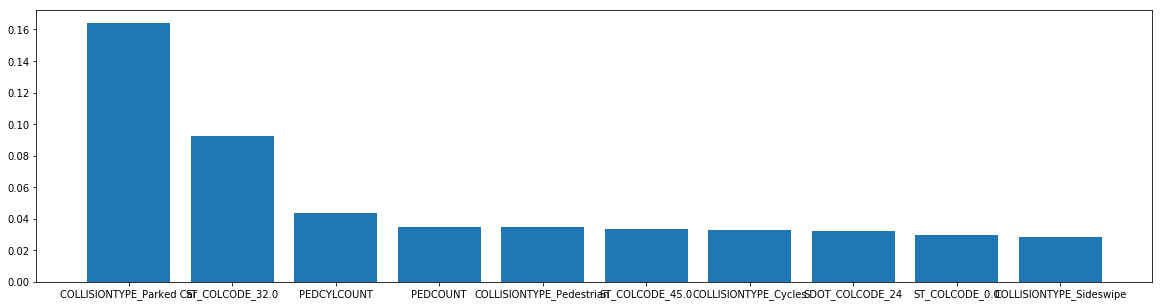

In [551]:
feature_importance(x_sampled.columns, xg.feature_importances_,10)

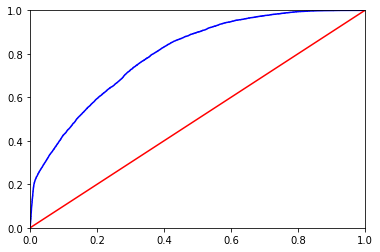

In [552]:
ROC_curve(y_test, gs_xg.best_estimator_.predict_proba(x_test)[:,1])

### 2.4 DEEP LEARNING

In [75]:
import tensorflow as tf


C:\ProgramData\OWTools\miniconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\OWTools\miniconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\OWTools\miniconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\OWTools\miniconda\lib\site-packages\tensorflow\python\framework\dty

In [585]:
int(y_train.sum())

38911

In [600]:
weight_for_0 = (1 / int(y_train.sum()))*(len(y_train))/2.0 
weight_for_1 = (1 / (len(y_train) - int(y_train.sum())))*(len(y_train))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=([x_train.shape[1]]), activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(64, activation = "relu"),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

print(model.summary())
model.compile(optimizer = "RMSprop", loss="binary_crossentropy",metrics = ["accuracy"])

history = model.fit(x_train_bal_sc, y_train_bal, epochs = 20, verbose = 1, 
                    validation_data = (x_test_sc,y_test), batch_size=1028,
                   )#class_weight=class_weight)

#history = model.fit(x_train_sc, y_train, epochs = 100, verbose = 1, 
#                    validation_data = (x_test,y_test), batch_size=1028,
#                   class_weight=class_weight)

#history = model.fit(temp, y_train, epochs = 30, verbose = 1, validation_data = (temp1,y_test), batch_size=32 )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 128)               21504     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 129       
Total params: 21,633
Trainable params: 21,633
Non-trainable params: 0
_________________________________________________________________
None
Train on 77822 samples, validate on 31081 samples
Epoch 1/20
77822/77822 [==============================] - 1s 16us/sample - loss: 0.5687 - acc: 0.6878 - val_loss: 0.5401 - val_acc: 0.6821
Epoch 2/20
77822/77822 [==============================] - 1s 10us/sample - loss: 0.5402 - acc: 0.7070 - val_loss: 0.5188 - val_acc: 0.6989
Epoch 3/20
77822/77822 [==============================] - 1s 10us/sam

In [601]:
results(y_test,model.predict_classes(x_test_sc), model.predict(x_test_sc))

Accuracy:  0.694
Balanced accuracy score 0.711
Confusion matrix: 
 [[14222  7131]
 [ 2381  7347]] 
 [[0.45757858 0.22943277]
 [0.07660629 0.23638236]]
F1 score:  0.607
Recall:  0.755
Precision:  0.507
ROC AUC score:  0.795


In [80]:
print(precision_score(y_test, model.predict_classes(x_test_sc)))
print(recall_score(y_test,model.predict_classes(x_test_sc)))

0.6162849021902692
0.37890625
